In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from utils import get_classifier_metrics
from utils import get_regression_metrics

## Paso 1: Planteamiento del problema

El objetivo es construir un modelo predictivo que pueda estimar la Prevalencia de la Obesidad (Obesity_prevalence) en diferentes condados (o áreas geográficas, ya que el documento tiene datos a nivel de condado) basándose en una variedad de factores demográficos, socioeconómicos, y de salud presentes en el dataset.

## Paso 2: Exploración

In [3]:
df = pd.read_csv("../data/raw/reg-demographic-health-data.csv")
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


## Paso 3: Análisis Descriptivo

In [4]:
df.shape

(3140, 108)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fips,3140.0,30401.640764,15150.559265,1001.0,18180.500000,29178.000000,45081.50000,5.604500e+04
TOT_POP,3140.0,104189.412420,333583.395432,88.0,10963.250000,25800.500000,67913.00000,1.010552e+07
0-9,3140.0,12740.302866,41807.301846,0.0,1280.500000,3057.000000,8097.00000,1.208253e+06
0-9 y/o % of total pop,3140.0,11.871051,2.124081,0.0,10.594639,11.802727,12.95184,2.546068e+01
19-Oct,3140.0,13367.976752,42284.392134,0.0,1374.500000,3274.000000,8822.25000,1.239139e+06
...,...,...,...,...,...,...,...,...
CKD_prevalence,3140.0,3.446242,0.568059,1.8,3.100000,3.400000,3.80000,6.200000e+00
CKD_Lower 95% CI,3140.0,3.207516,0.527740,1.7,2.900000,3.200000,3.50000,5.800000e+00
CKD_Upper 95% CI,3140.0,3.710478,0.613069,1.9,3.300000,3.700000,4.10000,6.600000e+00
CKD_number,3140.0,2466.234076,7730.422067,3.0,314.750000,718.000000,1776.25000,2.377660e+05


In [7]:
df.columns

Index(['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop',
       ...
       'COPD_number', 'diabetes_prevalence', 'diabetes_Lower 95% CI',
       'diabetes_Upper 95% CI', 'diabetes_number', 'CKD_prevalence',
       'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number',
       'Urban_rural_code'],
      dtype='object', length=108)

## Paso 4: Limpieza de Datos

### Limpieza de datos: Eliminar duplicados

In [8]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3135    False
3136    False
3137    False
3138    False
3139    False
Length: 3140, dtype: bool

### Limpieza de datos: Eliminar información irrelevante

In [9]:
df.drop(["fips", "0-9", "19-Oct", "20-29", "30-39", "40-49",
"50-59", "60-69", "70-79", "80+", "White-alone pop",
"Black-alone pop", "Native American/American Indian-alone pop",
"Asian-alone pop", "Hawaiian/Pacific Islander-alone pop",
"Two or more races pop", "POP_ESTIMATE_2018",
"N_POP_CHG_2018",
"GQ_ESTIMATES_2018", "R_DOMESTIC_MIG_2018",
"R_NET_MIG_2018",
"Less than a high school diploma 2014-18", "High school diploma only 2014-18",
"Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
"POVALL_2018", "PCTPOV017_2018", "PCTPOV517_2018",
"CI90LBINC_2018", "CI90UBINC_2018",
"Employed_2018", "Unemployed_2018",
"Median_Household_Income_2018", "STATE_NAME",
"Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)",
"Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)",
"Internal Medicine Primary Care (2019)", "COUNTY_NAME", "Family Medicine/General Practice Primary Care (2019)",
"Total Population", "Population Aged 60+", "Percent of Population Aged 60+",
"STATE_FIPS", "CNTY_FIPS", "county_pop2018_18 and older",
"anycondition_Lower 95% CI",
"anycondition_Upper 95% CI", "anycondition_number",
"Obesity_Lower 95% CI",
"Obesity_Upper 95% CI", "Obesity_number", "Heart disease_Lower 95% CI",
"Heart disease_Upper 95% CI", "Heart disease_number",
"COPD_Lower 95% CI",
"COPD_Upper 95% CI", "COPD_number", "diabetes_Lower 95% CI", "diabetes_Upper 95% CI",
"diabetes_number", "CKD_Lower 95% CI", "CKD_Upper 95% CI",
"CKD_number"],axis=1, inplace=True)

df

,TOT_POP,0-9 y/o % of total pop,10-19 y/o % of total pop,20-29 y/o % of total pop,30-39 y/o % of total pop,40-49 y/o % of total pop,50-59 y/o % of total pop,60-69 y/o % of total pop,70-79 y/o % of total pop,80+ y/o % of total pop,...,Total Hospitals (2019),Total Specialist Physicians (2019),ICU Beds_x,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,Urban_rural_code
0,55601,12.206615,13.735364,12.370281,12.749771,13.636445,13.917016,10.478229,7.284042,3.622237,...,1.148905,72.142154,6,47.6,35.8,7.9,8.6,12.9,3.1,3
1,218022,11.355276,12.344167,10.814964,11.564429,12.539102,13.753658,13.728890,9.602701,4.296814,...,4.505074,282.882982,51,40.2,29.7,7.8,8.6,12.0,3.2,4
2,24881,10.980266,11.896628,13.134520,12.865239,12.354809,13.174712,12.362847,9.018930,4.212049,...,0.514126,32.283033,5,57.5,40.7,11.0,12.1,19.7,4.5,6
3,22400,10.964286,11.589286,13.522321,13.897321,13.562500,13.906250,11.361607,7.691964,3.504464,...,0.462860,29.063942,0,51.6,38.7,8.6,10.0,14.1,3.3,2
4,57840,12.266598,13.087828,11.656293,11.901798,12.921853,13.561549,12.041840,8.525242,4.036999,...,1.195171,75.047251,6,46.3,34.0,9.2,10.5,13.5,3.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,43051,14.178532,14.694200,12.448027,15.277229,12.389956,12.220390,11.481731,5.105572,2.204362,...,2.160982,40.537033,10,40.3,33.6,5.9,6.6,8.9,2.6,5
3136,23081,10.328842,9.466661,12.854729,17.733200,14.830380,12.685759,12.456133,6.797799,2.846497,...,1.158570,21.733183,6,24.3,19.4,5.2,4.9,7.2,2.4,5
3137,20299,15.375142,15.788955,10.606434,13.311001,11.773979,11.990738,12.581901,6.074191,2.497660,...,1.018926,19.113638,6,42.2,34.2,7.2,8.0,10.4,3.0,5
3138,7885,10.881420,14.115409,9.067850,11.452124,11.414077,13.760304,14.178821,9.397590,5.732403,...,0.395794,7.424555,0,37.5,28.4,8.2,8.3,11.3,3.4,6


In [10]:
df.columns

Index(['TOT_POP', '0-9 y/o % of total pop', '10-19 y/o % of total pop',
       '20-29 y/o % of total pop', '30-39 y/o % of total pop',
       '40-49 y/o % of total pop', '50-59 y/o % of total pop',
       '60-69 y/o % of total pop', '70-79 y/o % of total pop',
       '80+ y/o % of total pop', '% White-alone', '% Black-alone',
       '% NA/AI-alone', '% Asian-alone', '% Hawaiian/PI-alone',
       '% Two or more races', 'R_birth_2018', 'R_death_2018',
       'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a high school diploma only 2014-18',
       'Percent of adults completing some college or associate's degree 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'PCTPOVALL_2018', 'MEDHHINC_2018', 'Civilian_labor_force_2018',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Active Physicians per 100000 Populatio

## Paso 5: Análisis de Variables

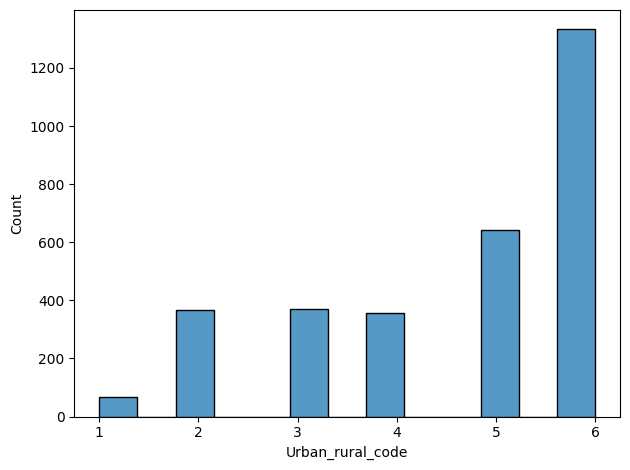

In [11]:
sns.histplot( data=df, x="Urban_rural_code")
plt.tight_layout()
plt.show()

### Análisis numérico-numérico

In [12]:
pd.set_option("display.max_rows", None)

In [13]:
corr = df.corr(numeric_only=True)

umbral = 0.8
corr_pairs = []

for i, col1 in enumerate(corr.columns):
    for col2 in corr.columns[i+1:]:  
        valor = corr.loc[col1, col2]
        if valor > umbral:
            corr_pairs.append((col1, col2, valor))

corr_pairs

[('TOT_POP', 'Civilian_labor_force_2018', np.float64(0.998041912256138)),
 ('TOT_POP',
  'Total nurse practitioners (2019)',
  np.float64(0.9638177808583888)),
 ('TOT_POP',
  'Total physician assistants (2019)',
  np.float64(0.9418263237210897)),
 ('TOT_POP', 'Total Hospitals (2019)', np.float64(0.9250326876351878)),
 ('TOT_POP',
  'Total Specialist Physicians (2019)',
  np.float64(0.9636099331025187)),
 ('TOT_POP', 'ICU Beds_x', np.float64(0.9108244182391105)),
 ('0-9 y/o % of total pop', 'R_birth_2018', np.float64(0.8844275801653143)),
 ('60-69 y/o % of total pop',
  '70-79 y/o % of total pop',
  np.float64(0.8599535831094334)),
 ('MEDHHINC_2018',
  'Med_HH_Income_Percent_of_State_Total_2018',
  np.float64(0.8334111761068165)),
 ('Civilian_labor_force_2018',
  'Total nurse practitioners (2019)',
  np.float64(0.9650980948756791)),
 ('Civilian_labor_force_2018',
  'Total physician assistants (2019)',
  np.float64(0.9421659345021494)),
 ('Civilian_labor_force_2018',
  'Total Hospitals (

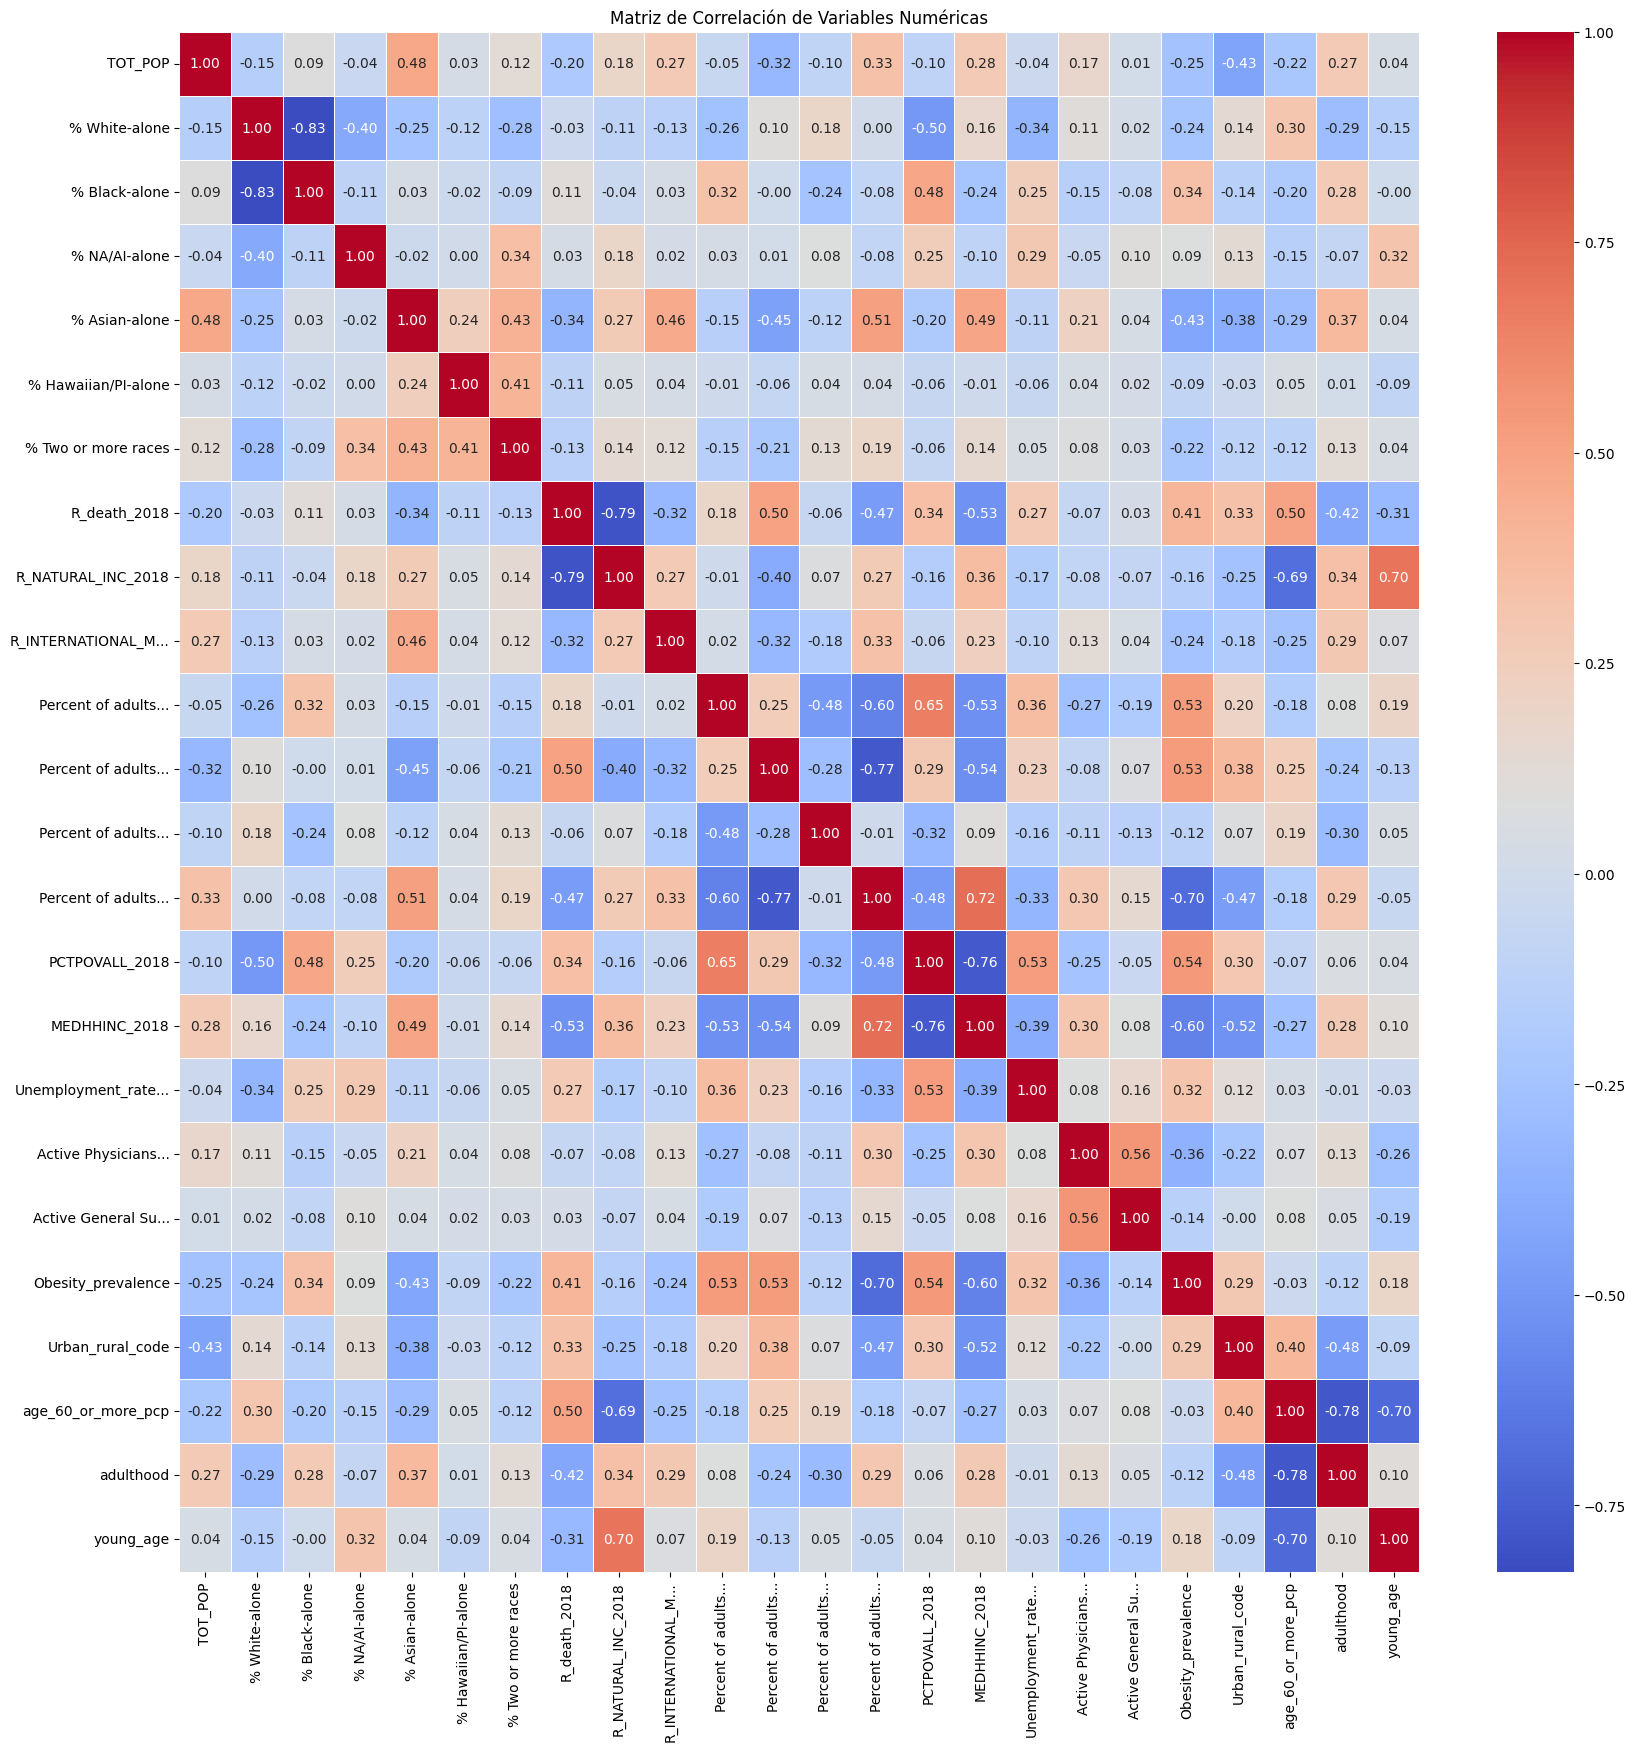

In [37]:
correlation_matrix = df.corr()
short_labels = [col if len(col) <= 20 else col[:17] + "..."
                for col in correlation_matrix.columns]
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5,  
            xticklabels=short_labels,
            yticklabels=short_labels)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

Correlaciones Positivas

diabetes_prevalence	`+0.84` (Muy Fuerte)	La diabetes y la obesidad están extremadamente ligadas a nivel biológico y de estilo de vida. Es la correlación más alta.

Heart disease_prevalence	`+0.79` (Muy Fuerte)	Las enfermedades cardíacas también están fuertemente asociadas a la obesidad, compartiendo factores de riesgo.

CKD_prevalence	`+0.74` (Fuerte)	La enfermedad renal crónica (CKD) tiene una alta correlación, también ligada a la diabetes y la presión arterial alta (comorbilidades de la obesidad).

Unemployment_rate_2018	`+0.41` (Moderada)	El desempleo sugiere menores ingresos y quizás un acceso limitado a alimentos saludables y atención médica.

% below_poverty_2018	`+0.35` (Moderada)	La pobreza está asociada con menor calidad de dieta y acceso a recursos.

Correlaciones Negativas

% non-hispanic white alone	`-0.64` (Fuerte)	Existe una fuerte correlación negativa, lo que indica que las áreas con mayor porcentaje de población blanca no hispana tienen una menor prevalencia de obesidad.

% adults with a bachelor's degree or higher 2014-18	`-0.61` (Fuerte)	Un mayor nivel de educación superior se asocia con una menor obesidad. La educación influye en la conciencia de la salud y el nivel socioeconómico.

MEDHINC_2018	`-0.54` (Moderada-Fuerte)	Un mayor ingreso medio del hogar se asocia con una menor obesidad, lo que sugiere un factor socioeconómico importante.

In [16]:
df.columns

Index(['TOT_POP', '0-9 y/o % of total pop', '10-19 y/o % of total pop',
       '20-29 y/o % of total pop', '30-39 y/o % of total pop',
       '40-49 y/o % of total pop', '50-59 y/o % of total pop',
       '60-69 y/o % of total pop', '70-79 y/o % of total pop',
       '80+ y/o % of total pop', '% White-alone', '% Black-alone',
       '% NA/AI-alone', '% Asian-alone', '% Hawaiian/PI-alone',
       '% Two or more races', 'R_birth_2018', 'R_death_2018',
       'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018',
       'Percent of adults with less than a high school diploma 2014-18',
       'Percent of adults with a high school diploma only 2014-18',
       'Percent of adults completing some college or associate's degree 2014-18',
       'Percent of adults with a bachelor's degree or higher 2014-18',
       'PCTPOVALL_2018', 'MEDHHINC_2018', 'Civilian_labor_force_2018',
       'Unemployment_rate_2018', 'Med_HH_Income_Percent_of_State_Total_2018',
       'Active Physicians per 100000 Populatio

In [17]:
pd.set_option("display.max_rows", 50)

In [18]:
df.drop(["Civilian_labor_force_2018", "Total nurse practitioners (2019)",
         "Total physician assistants (2019)", "Total Hospitals (2019)",
         "Total Specialist Physicians (2019)", "ICU Beds_x",
         "R_birth_2018", "Med_HH_Income_Percent_of_State_Total_2018",
         "Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)",
         "Active Primary Care Physicians per 100000 Population 2018 (AAMC)",
         "anycondition_prevalence", "COPD_prevalence", "diabetes_prevalence", 
         "Heart disease_prevalence", "CKD_prevalence"], 
         axis=1, inplace=True)


In [19]:
corr = df.corr(numeric_only=True)

target = "Obesity_prevalence"
corr_target = corr[target].sort_values(ascending=False)
corr_target

Obesity_prevalence                                                         1.000000
PCTPOVALL_2018                                                             0.537471
Percent of adults with a high school diploma only 2014-18                  0.532343
Percent of adults with less than a high school diploma 2014-18             0.531818
R_death_2018                                                               0.405994
% Black-alone                                                              0.338429
Unemployment_rate_2018                                                     0.317041
Urban_rural_code                                                           0.285761
0-9 y/o % of total pop                                                     0.213080
10-19 y/o % of total pop                                                   0.109600
% NA/AI-alone                                                              0.085441
80+ y/o % of total pop                                                     0

## Paso 6: Ingeniería de características

### Análisis de valores faltantes

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 30 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   TOT_POP                                                                  3140 non-null   int64  
 1   0-9 y/o % of total pop                                                   3140 non-null   float64
 2   10-19 y/o % of total pop                                                 3140 non-null   float64
 3   20-29 y/o % of total pop                                                 3140 non-null   float64
 4   30-39 y/o % of total pop                                                 3140 non-null   float64
 5   40-49 y/o % of total pop                                                 3140 non-null   float64
 6   50-59 y/o % of total pop                                                

### Inferencia de nuevas características

In [21]:
df["age_60_or_more_pcp"] = (df["60-69 y/o % of total pop"]
                            +df["70-79 y/o % of total pop"]
                            +df["80+ y/o % of total pop"]
                          )
df["adulthood"] = (df["20-29 y/o % of total pop"]
                  +df["30-39 y/o % of total pop"]
                  +df["40-49 y/o % of total pop"]
                  +df["50-59 y/o % of total pop"]
                 )
       
df["young_age"] = (df["0-9 y/o % of total pop"]
                  +df["10-19 y/o % of total pop"]
                  )


df.drop(["60-69 y/o % of total pop",
         "70-79 y/o % of total pop",
         "80+ y/o % of total pop",
         "20-29 y/o % of total pop",
         "30-39 y/o % of total pop",
         "40-49 y/o % of total pop",
         "50-59 y/o % of total pop",
         "0-9 y/o % of total pop",
         "10-19 y/o % of total pop"],
         axis=1, inplace=True)


Es la suma de las columnas para crear nuevas características: el porcentaje de la población con 60 años o más, el porcentaje de la población en edad adulta principal (de 20 a 59 años), el porcentaje de la población en edad temprana/juventud (de 0 a 19 años).

df.drop() para eliminar todas las columnas originales de porcentaje de edad que se utilizaron para crear las tres nuevas características. Esto se hace típicamente para evitar la multicolinealidad

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 24 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   TOT_POP                                                                  3140 non-null   int64  
 1   % White-alone                                                            3140 non-null   float64
 2   % Black-alone                                                            3140 non-null   float64
 3   % NA/AI-alone                                                            3140 non-null   float64
 4   % Asian-alone                                                            3140 non-null   float64
 5   % Hawaiian/PI-alone                                                      3140 non-null   float64
 6   % Two or more races                                                     

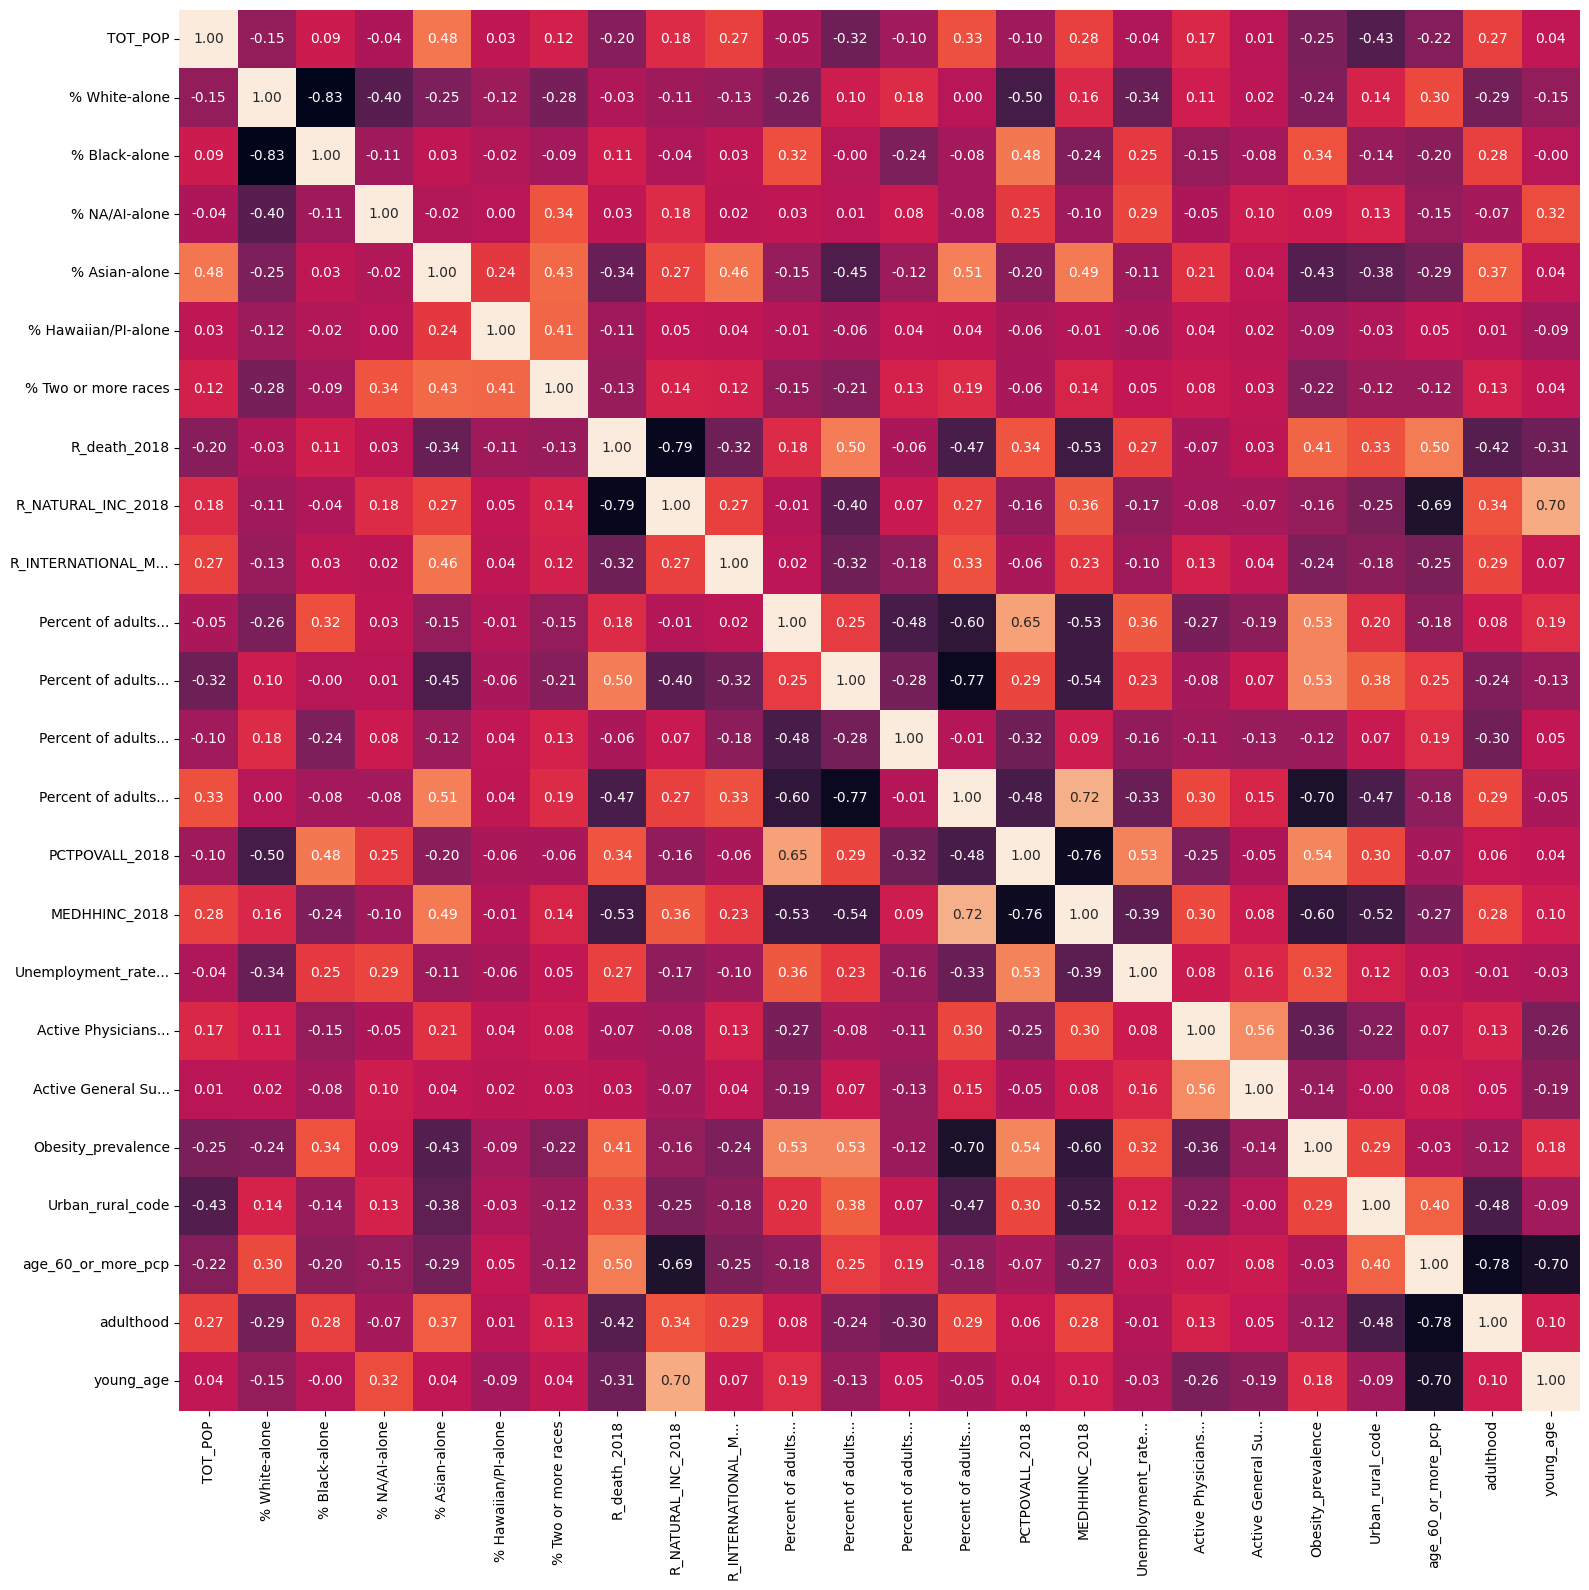

In [35]:
corr_y = df.corr(numeric_only=True)

short_labels = [col if len(col) <= 20 else col[:17] + "..."
                for col in corr_y.columns]

plt.figure(figsize=(16, 16))
sns.heatmap(data=corr_y, annot=True,
            fmt=".2f", cbar=False,
            xticklabels=short_labels,
            yticklabels=short_labels)

plt.tight_layout()
plt.show()


## Paso 7: Split 

In [24]:
df.shape

(3140, 24)

In [25]:
X = df.drop("Obesity_prevalence", axis=1)
y = df["Obesity_prevalence"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

## Paso 8: Encoding & Scaling 

### Normalización o Escalado Mínimo-Máximo

In [26]:
num_variables = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
norm_scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[num_variables] = norm_scaler.fit_transform(X_train[num_variables])

# 3. Transformar X_test con el mismo scaler
X_test_scaled = X_test.copy()
X_test_scaled[num_variables] = norm_scaler.transform(X_test[num_variables])

## Paso 9: modelo

In [27]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [28]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
y_pred = lr_model.predict(X_test)

f"Error cuadrático medio: {mean_squared_error(y_test, y_pred)} Coeficiente de determinación: {r2_score(y_test, y_pred)}"

'Error cuadrático medio: 9.047402937630812 Coeficiente de determinación: 0.5482639374806383'

In [30]:
X_test

,TOT_POP,% White-alone,% Black-alone,% NA/AI-alone,% Asian-alone,% Hawaiian/PI-alone,% Two or more races,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,...,Percent of adults with a bachelor's degree or higher 2014-18,PCTPOVALL_2018,MEDHHINC_2018,Unemployment_rate_2018,Active Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Urban_rural_code,age_60_or_more_pcp,adulthood,young_age
2590,179436,84.819100,11.386232,0.862146,0.817562,0.147128,1.967833,7.7,5.2,0.8,...,23.1,8.8,76792,3.3,224.8,6.2,2,18.587686,52.067590,29.344725
2946,91185,52.348522,42.409388,0.411252,1.870922,0.128311,2.831606,9.2,3.7,0.9,...,28.1,10.9,69753,3.2,263.2,7.3,2,20.570269,52.956078,26.473652
1902,10710,82.502334,11.970121,0.550887,2.194211,0.093371,2.689076,5.4,3.1,1.4,...,17.9,8.3,65955,3.7,255.0,7.1,5,23.492063,51.624650,24.883287
335,11736,84.057601,12.397751,0.996933,0.485685,0.076687,1.985344,8.5,-0.3,1.4,...,17.1,22.8,40297,3.5,265.2,6.9,6,31.654738,50.792434,17.552829
1324,55922,95.027002,1.369765,0.733164,1.258896,0.042917,1.568256,7.2,3.5,0.1,...,20.5,6.4,82814,3.4,302.7,7.4,2,22.046779,53.004184,24.949036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,2042,39.030362,0.293830,54.554358,0.244858,0.000000,5.876592,15.1,7.3,0.0,...,13.7,35.2,32780,4.9,240.4,9.2,6,22.037218,44.221352,33.741430
3109,103718,95.786652,1.212904,0.481112,1.129023,0.059777,1.330531,9.0,0.0,0.3,...,28.3,10.1,64234,2.9,264.9,7.9,5,24.741125,51.030679,24.228196
1004,20388,95.448303,2.109084,0.515009,0.362959,0.009810,1.554836,10.4,2.2,0.5,...,11.1,18.8,47284,5.4,230.9,8.3,6,26.711791,48.248970,25.039239
447,85219,68.934158,26.895411,0.496368,1.605276,0.188925,1.879862,11.2,-0.4,1.3,...,29.6,16.6,53906,3.7,228.7,7.0,4,27.175865,48.730917,24.093219


In [31]:
y_test

2590    36.4
2946    37.1
1902    34.4
335     33.7
1324    28.2
        ... 
2406    45.7
3109    32.2
1004    39.8
447     31.8
1752    32.1
Name: Obesity_prevalence, Length: 628, dtype: float64

Regularizacion

In [32]:
lasso_model = Lasso(alpha=0.09, max_iter=1000, random_state=18)
lasso_model.fit(X_train, y_train)  # entrenamiento

lasso_y_pred_test = lasso_model.predict(X_test)  # Predicción en test
lasso_y_pred_train = lasso_model.predict(X_train)  # Predicción en train
get_regression_metrics(lasso_y_pred_test, y_test, lasso_y_pred_train, y_train)

,R2,MAE,MAPE,MSE,RMSE
Train set,0.642458,1.735321,6.250418,7.325916,2.706643
Test set,0.603813,1.871605,6.665952,7.934860,2.816888
Difference,-0.038645,0.136284,0.415534,0.608944,0.110245


In [38]:
with open('../models/obesity_scaler.pkl', 'wb') as file:
    pickle.dump(norm_scaler, file)